<b>PART 1 </b>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

data = pd.read_csv('product_sales.csv')


In [2]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

data['Log_Units_Sold'] = np.log1p(data['Units_Sold'])

label_encoder = LabelEncoder()
data['Product_Category'] = label_encoder.fit_transform(data['Product_Category'])

categorical_columns = ['Seasonal', 'Material', 'Color']
data_encoded = pd.get_dummies(data, columns=categorical_columns)

data_encoded = data_encoded.astype(int)

In [3]:
data_encoded['Revenue'] = data_encoded['Retail_Price'] * data_encoded['Units_Sold']

data_encoded['Log_Retail_Price'] = np.log1p(data['Retail_Price'])

data_encoded['Seasonal_x_Product_Category'] = data_encoded['Seasonal_Yes'] * data_encoded['Product_Category']
data_encoded['Material_x_Color'] = data_encoded['Material_Cotton'] * data_encoded['Color_Blue']


In [4]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data_encoded[['Log_Units_Sold', 'Revenue', 'Log_Retail_Price']])
poly_feature_names = poly.get_feature_names_out(['Log_Units_Sold', 'Revenue', 'Log_Retail_Price'])

poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data_encoded.index)

data_encoded = pd.concat([data_encoded, poly_df], axis=1)

X = data_encoded.drop(columns=['Retail_Price'])
y = data_encoded['Retail_Price']

In [5]:
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [6]:
y_pred = random_forest.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.0035944999999999497
Mean Squared Error (MSE): 0.0018033750000000055
R² Score: 0.9999999095409128


<b>PART 2 </b>

In [10]:
X = data_encoded.drop(columns=['Product_Category'])
y = data_encoded['Product_Category']

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [12]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=1, error_score='raise')

In [13]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  42.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  42.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  43.9s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  54.1s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  52.2s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  52.6s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimator

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(random_state=42), n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   random_state=42, verbose=2)

In [14]:
best_model = random_search.best_estimator_

rfe = RFE(estimator=best_model, n_features_to_select=20)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(max_depth=10, max_features='log2',
                                     min_samples_split=5, random_state=42),
    n_features_to_select=20)

In [15]:
selected_features = X_train.columns[rfe.support_]

In [16]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [17]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_selected, y_train)

GradientBoostingClassifier(random_state=42)

In [18]:
y_pred = gb_classifier.predict(X_test_selected)


In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.60065


In [20]:
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

Classification Report:
                precision    recall  f1-score   support

     Clothing       0.57      0.63      0.60      4051
  Electronics       0.54      0.63      0.58      4031
       Health       0.53      0.64      0.58      4006
Home & Garden       0.81      0.54      0.65      3953
       Sports       0.68      0.56      0.61      3959

     accuracy                           0.60     20000
    macro avg       0.62      0.60      0.60     20000
 weighted avg       0.62      0.60      0.60     20000



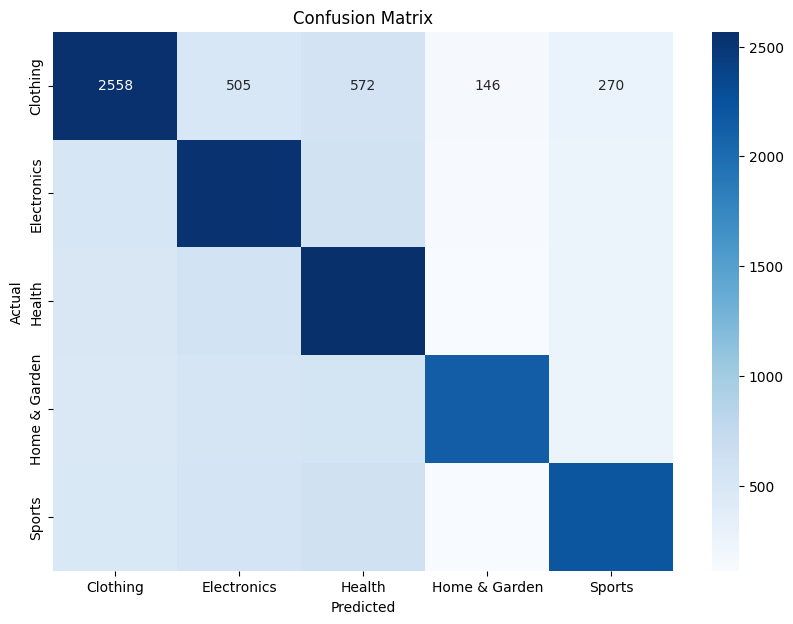

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()